# Exploratory Data Analysis

In [1]:
# Imports 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from collections import Counter
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load data
data = pd.read_csv("filtered_data_new.csv")
data.shape

(20579, 97)

In [3]:
# Preliminary cleaning

data_cleaned = data.drop_duplicates()
data_cleaned = data_cleaned.dropna()

# Identify + Remove Constant features
constant_columns = data_cleaned.columns[data.nunique() == 1]
data_cleaned = data_cleaned.drop(columns=constant_columns)
data_cleaned.to_csv("data_cleaned.csv", index=False)



## Data Introduction

The data used in this Exploratory Data Analysis is a combination of geometric and environmental features of the particles. 

To create a random subsample, 50 FlowCam mosaics were randomly selected from the Master Table. Then, a "Master Geometric Features" file was created by stacking all csvs (containing geometric features) associated with subsampled mosaics. 

Then, to ensure both geometric and environmental information were accessible in one file, the Geometric features file was merged with the original Master Table. 

Finally, the data was cleaned. Any duplicate rows were removed (original Master Table contained some duplicate rows, which were carried over into the merged data). Any variables that only took one value were also removed. For modelling purposes, categorical variables were one-hot-encoded. This resulted in a total of 102 features and one target variable, the class of the particle. 

### Questions to answer

The purpose of this EDA is to answer questions that have been developed about the data structure, the answers to which will inform our analysis. The following questions will be addressed in the following sections:

- Is this an imabalanced dataset? What are the distributions of the classes we care about? 
- Will the assumptions of logistic regression be met? 
    - Is there a linear relationship between continuous variables and the log-odds of predicted probabilities? 
    - Is multicollinearity present? 
- Are some classes similar to others? Are there classes that are likely to be mistaken for one another? 

### Class Distribution


In [4]:
# How many observations of each class do we have? 
class_counts = data_cleaned["Class"].value_counts()
class_counts

Class
Calanoid_1       3917
Bosmina_1         341
Herpacticoida     156
Chironomid        121
Chydoridae          2
Daphnia             1
Name: count, dtype: int64

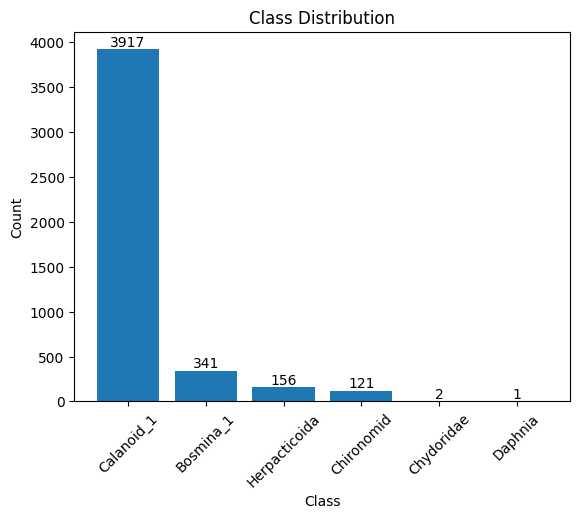

In [6]:
# As barplot 
bar_plt = plt.bar(class_counts.index, class_counts.values)
# Rotate axis ticks
plt.xticks(rotation=45)
# Add bar labels
for bar in bar_plt:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')
# Label axes
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

It appears a large majority of particles in our sample are of class *Calanoid_1*. We should take this class imbalance into account when creating our training, testing, and validation sets. 

### Logistic Regression Assumptions

First, we will check if there is a linear relationship between class predictions and continouous variables. 


In [8]:
# Preprocessing 
numerical_df = data_cleaned.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns=["Class.Particle.ID"])
non_numerical_cols = list(set(data_cleaned.columns)-set(numerical_df.columns))
non_numerical_df = data_cleaned[non_numerical_cols]
non_numerical_df = non_numerical_df.drop(columns=["Image.File", "Date", "Rep", "Time", "Original.Reference.ID",  
                                                  "Class", 
                                                  "Key", "tifffile", "Timestamp"])
non_numerical_cols = non_numerical_df.columns
nonnumerical_encoded = pd.get_dummies(non_numerical_df, dtype=int)

data_encoded = pd.concat([numerical_df, nonnumerical_encoded], axis=1)

# Encode target
# Encode the target variable
data_cleaned['Class'] = data_cleaned['Class'].astype('category')
class_mapping = dict(enumerate(data_cleaned['Class'].cat.categories))
data_cleaned['Class'] = data_cleaned['Class'].cat.codes

# Run Logistic regression 

# Features and target 
y = data_cleaned["Class"]
X = data_encoded

logistic_model = LogisticRegression()
logistic_model.fit(X, y)
y_pred = logistic_model.predict(X)
y_prob = logistic_model.predict_proba(X)



In [9]:
# Linearity

continuous_vars = X.select_dtypes(include=['float']).columns
scatter_data = X[continuous_vars]

# Choose a class of interest (e.g., 'Calanoid_1')
class_of_interest = list(class_mapping.keys())[list(class_mapping.values()).index('Calanoid_1')]
y_prob_class = y_prob[:, class_of_interest]

# Compute the logit for the chosen class
logit = np.log(y_prob_class / (1 - y_prob_class))

# Add the logit to the DataFrame
scatter_data = pd.DataFrame(X, columns=X.columns)
scatter_data['logit'] = logit
scatter_data['y_prob_class'] = y_prob_class


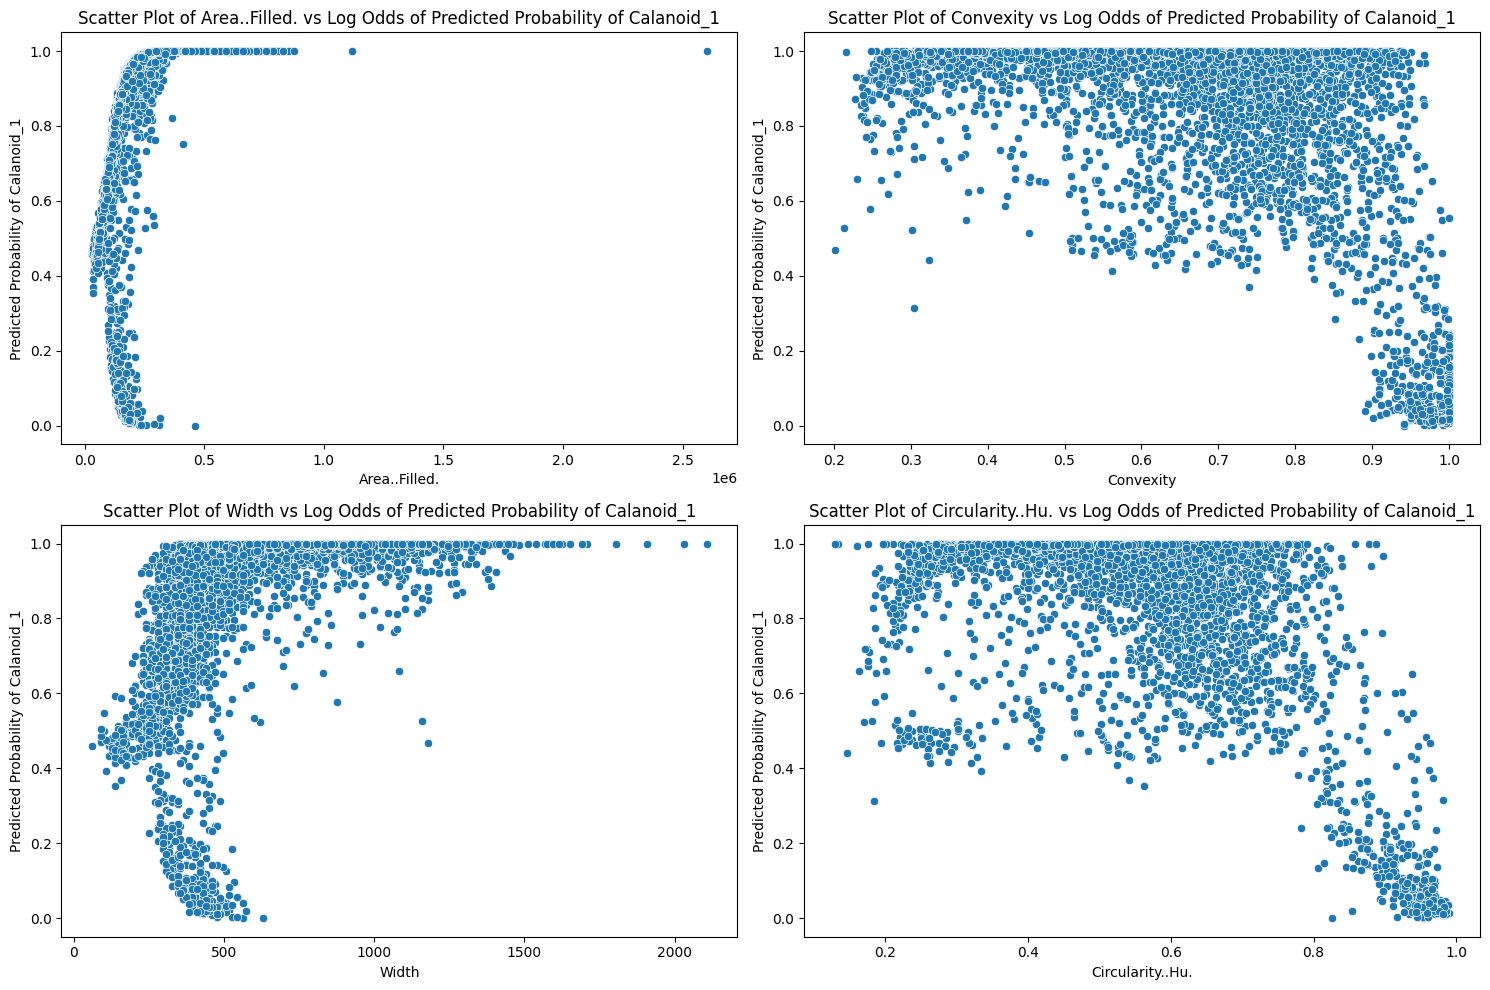

In [10]:
# Select specific variables for plotting 
scatter_data_filtered = scatter_data[["Area..Filled.", "Convexity", "Width", "Circularity..Hu.", "y_prob_class"]]

# Plotting with non-linear fit line using statsmodels
num_plots = len(scatter_data_filtered.columns) - 1  # Exclude the 'y_prob_class' column
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, column in enumerate(scatter_data_filtered.drop(columns=["y_prob_class"])):  # Exclude the 'y_prob_class' column
    ax = axes[i // num_cols, i % num_cols]
    sns.scatterplot(x=scatter_data_filtered[column], y=scatter_data_filtered['y_prob_class'], ax=ax)

    ax.set_title(f'Scatter Plot of {column} vs Log Odds of Predicted Probability of {class_mapping[class_of_interest]}')
    ax.set_xlabel(column)
    ax.set_ylabel(f'Predicted Probability of {class_mapping[class_of_interest]}')

# Remove any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

Because this is a multiple logistic regression problem, with all six classes of interest as possible outcomes, we opted to check the linearity condition by filtering just to "Calanoid_1" predictions, our largest class. 

We ideally would like to see a linear relationship between any continuous variables and the log-odds of the predicted class probability. It was found that the majority of variables did violate this relationship. Four variables are displayed here to illustrate the sorts of relationships present. While some curvature is expected due to the boundedness of the odds ratio, all of these variables exhibhit more curvature than we would like to see. 

Now, we will check for multicollinearity. We will use Python's built-in Variance Inflation Factor function. 

In [11]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False).head(20)

vif_data_sorted.style.format({'VIF': "{:.2f}"})

,feature,VIF
50,WaterT,inf
84,csvfile_x_20180514_FISHI_157_2mm_rep2_data.csv,inf
136,csvfile_y_20210419_NOTTA_040_2mm_Rep2_MS_data.csv,inf
92,csvfile_x_20210419_NOTTA_040_2mm_Rep2_MS_data.csv,inf
75,Loc_FISHI,inf
73,FR_Fixed,inf
103,SITE_ST24,inf
129,csvfile_y_20180528_FISHI_293_2mm_rep2_data.csv,inf
112,WIND_180-07,inf
49,gdd2,inf


Due to the `inf` VIF of some features, we have reason to believe some are linear combinations of other features. Additional investigation into the structure of these variables and whether this is a cause for concern will be required. 

It appears as though the assumptions for logistic regression may not be met. We appear to have some correlated data, and not all continuous variables exhibit a linear relationship with the log odds of the probabilities. In this case, it may be wise to proceed with a more assumption-free modelling techinique (like the multilayer perceptron) for the geometric and environmental features. 

### Clustering 

To help us understand which classes are likely to be mistaken for one another, we can perform a clustering algorithm. First, we are going to standardize our features. Then, we're going to perform Principle Component Analysis to reduce the number of features, for visualization purposes. Finally, we'll plot the results to understand how the classes within the different clusters are distributed. 

In [10]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

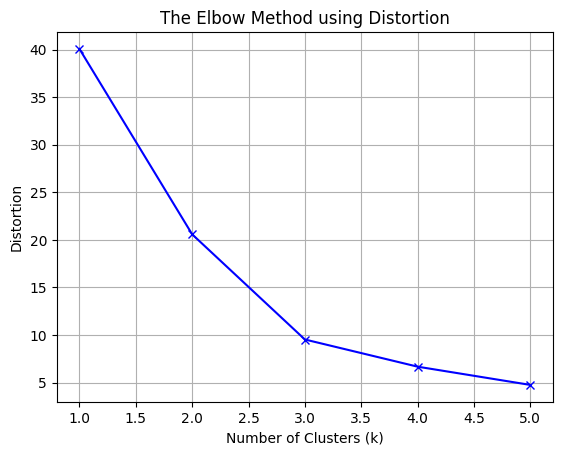

In [14]:
# Initialize lists to store distortion and inertia values
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 6)

# Fit K-means for different values of k
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X_pca)

    # Calculate distortion as the average squared distance from points to their cluster centers
    distortions.append(sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_, 'euclidean'), 
                                  axis=1)**2) / X_pca.shape[0])

    # Inertia is calculated directly by KMeans
    inertias.append(kmeanModel.inertia_)

    # Store the mappings for easy access
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

# Distortion and inertia are two ways to measure distance. 
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.grid()
plt.show()

Based on the elbow plot, it looks like the optimal number of clusters is likely k=3. 

In [12]:
data_cleaned['Class Names'] = data_cleaned['Class'].map(class_mapping)


# Perform clustering using KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add cluster labels and PCA components to the DataFrame
data_cleaned['Cluster'] = clusters
data_cleaned['PCA1'] = X_pca[:, 0]
data_cleaned['PCA2'] = X_pca[:, 1]

# Print the distribution of classes within each cluster
for cluster in sorted(data_cleaned['Cluster'].unique()):
    cluster_data = data_cleaned[data_cleaned['Cluster'] == cluster]
    class_counts = Counter(cluster_data['Class Names'])
    print(f"Cluster {cluster}:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")

Cluster 0:
  Calanoid_1: 36078
  Chironomid: 280
Cluster 1:
  Calanoid_1: 114044
  Herpacticoida: 1113
  Chironomid: 2685
  Bosmina_1: 192
Cluster 2:
  Calanoid_1: 30517
  Herpacticoida: 10818
  Bosmina_1: 32596
  Chironomid: 4090
  Daphnia: 111
  Chydoridae: 88


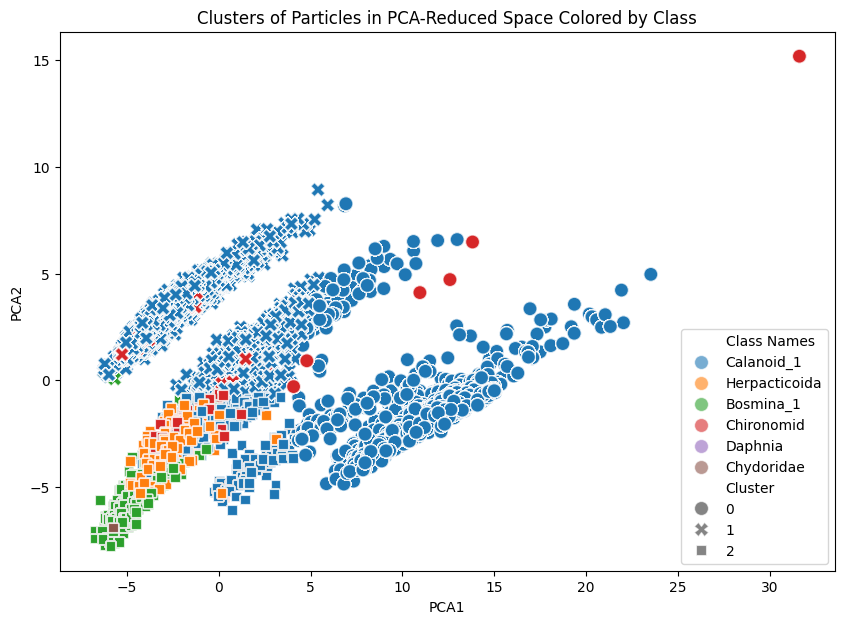

In [13]:
# PCA Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Class Names', style='Cluster', data=data_cleaned, palette='tab10', s=100, alpha=0.6)
plt.title('Clusters of Particles in PCA-Reduced Space Colored by Class')
plt.show()

The results of this plot tell us that depending on the cluster -- and even within each cluster -- different classes are more "similar" to each other. For example, in Cluster 2 (the squares), it seems like Bosmina_1 and Herpacticoida tend to be very similar to one another, whereas Calanoid_1 is more separate.